##IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    Trainer, TrainingArguments
)
import torch


##LOAD & CEK DATASET

In [2]:
df = pd.read_csv("/content/emotions_dataset.csv")

print(df.head())
print(df.info())


                                            Sentence      Label
0  Unfortunately later died from eating tainted m...  happiness
1  Last time I saw was loooong ago. Basically bef...    neutral
2  You mean by number of military personnel? Beca...    neutral
3  Need to go middle of the road no NAME is going...    sadness
4           feel melty miserable enough imagine must    sadness
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131306 entries, 0 to 131305
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  131306 non-null  object
 1   Label     131306 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None


##EXPLORATORY DATA ANALYSIS (EDA)

Jumlah data: 131306
Jumlah kolom: 2

Distribusi Label:
Label
happiness    31205
sadness      17809
neutral      15733
anger        13341
love         10512
fear          8795
disgust       8407
confusion     8209
surprise      4560
shame         4248
guilt         3470
sarcasm       2534
desire        2483
Name: count, dtype: int64


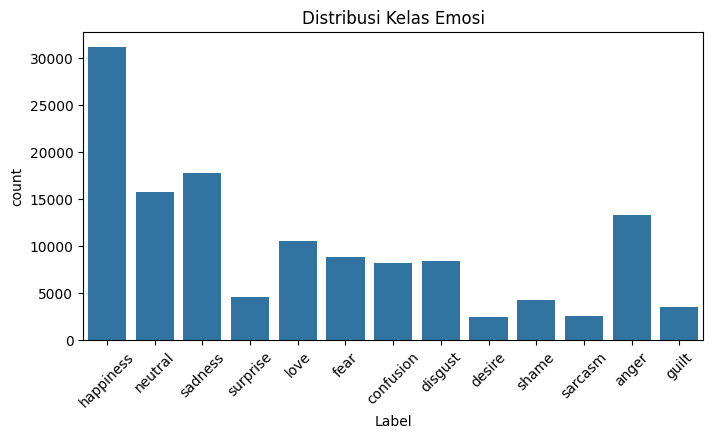

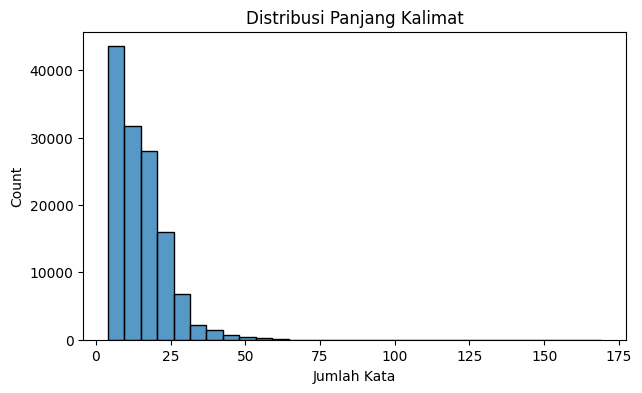

In [3]:
print("Jumlah data:", df.shape[0])
print("Jumlah kolom:", df.shape[1])

print("\nDistribusi Label:")
print(df['Label'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='Label', data=df)
plt.title("Distribusi Kelas Emosi")
plt.xticks(rotation=45)
plt.show()

# Panjang teks
df['word_length'] = df['Sentence'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,4))
sns.histplot(df['word_length'], bins=30)
plt.title("Distribusi Panjang Kalimat")
plt.xlabel("Jumlah Kata")
plt.show()


##DATA PREPROCESSING

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['Sentence_clean'] = df['Sentence'].apply(clean_text)

# Encode label
le = LabelEncoder()
df['Label_enc'] = le.fit_transform(df['Label'])

num_classes = df['Label_enc'].nunique()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['Sentence_clean'],
    df['Label_enc'],
    test_size=0.2,
    random_state=42,
    stratify=df['Label_enc']
)


## Model 3 - DISTILBERT (PRETRAINED)

In [5]:
# Class Weight(Imbalance data)
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)


In [6]:
# Dataset Class Pytorch
from torch.utils.data import Dataset, DataLoader
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx])
        }


In [9]:
# Tokenizer
distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_ds_distil = EmotionDataset(X_train, y_train, distil_tokenizer)
test_ds_distil  = EmotionDataset(X_test, y_test, distil_tokenizer)


In [10]:
#Model DistilBert
distil_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_classes
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


In [12]:
#(CLASS-WEIGHTED LOSS)
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [18]:
# Training
from transformers import TrainingArguments, EarlyStoppingCallback

training_args_distil = TrainingArguments(
    output_dir="./distilbert_output",
    num_train_epochs=10,                # 🔥 NAIK
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    report_to="none",
    fp16=torch.cuda.is_available()       # otomatis GPU
)

trainer_distil = Trainer(
    model=distil_model,
    args=training_args_distil,
    train_dataset=train_ds_distil,
    eval_dataset=test_ds_distil,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


trainer_distil.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.636100,1.105706,0.665372
2,0.512100,1.205814,0.658137
3,0.541600,1.258493,0.649950


TrainOutput(global_step=19698, training_loss=0.5500025997574359, metrics={'train_runtime': 1561.0292, 'train_samples_per_second': 672.915, 'train_steps_per_second': 42.062, 'total_flos': 1.0438226327135232e+16, 'train_loss': 0.5500025997574359, 'epoch': 3.0})

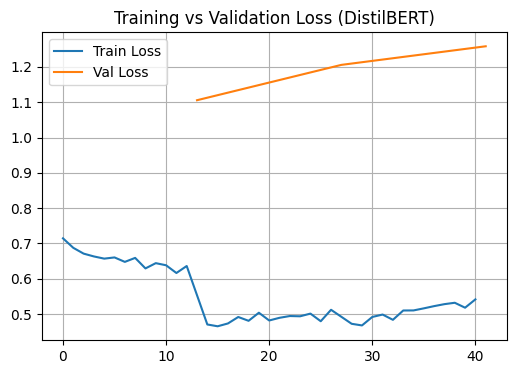

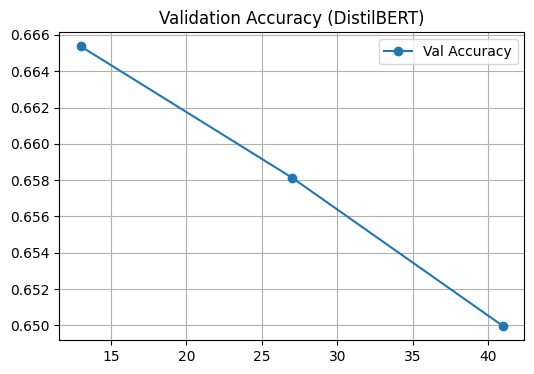

In [19]:
# Evaluasi
import pandas as pd
import matplotlib.pyplot as plt

log_distil = pd.DataFrame(trainer_distil.state.log_history)

# ===== LOSS =====
plt.figure(figsize=(6,4))
plt.plot(log_distil[log_distil["loss"].notna()]["loss"], label="Train Loss")
plt.plot(log_distil[log_distil["eval_loss"].notna()]["eval_loss"], label="Val Loss")
plt.title("Training vs Validation Loss (DistilBERT)")
plt.legend()
plt.grid(True)
plt.show()

# ===== ACCURACY =====
plt.figure(figsize=(6,4))
plt.plot(
    log_distil[log_distil["eval_accuracy"].notna()]["eval_accuracy"],
    marker="o",
    label="Val Accuracy"
)
plt.title("Validation Accuracy (DistilBERT)")
plt.legend()
plt.grid(True)
plt.show()



=== Classification Report DistilBERT ===
              precision    recall  f1-score   support

       anger       0.63      0.66      0.65      2668
   confusion       0.40      0.39      0.39      1642
      desire       0.89      0.83      0.86       497
     disgust       0.43      0.48      0.46      1681
        fear       0.74      0.78      0.76      1759
       guilt       0.68      0.42      0.52       694
   happiness       0.76      0.76      0.76      6241
        love       0.68      0.72      0.70      2102
     neutral       0.55      0.61      0.58      3147
     sadness       0.77      0.79      0.78      3562
     sarcasm       1.00      0.98      0.99       507
       shame       0.51      0.44      0.47       850
    surprise       0.71      0.39      0.50       912

    accuracy                           0.67     26262
   macro avg       0.67      0.63      0.65     26262
weighted avg       0.67      0.67      0.66     26262



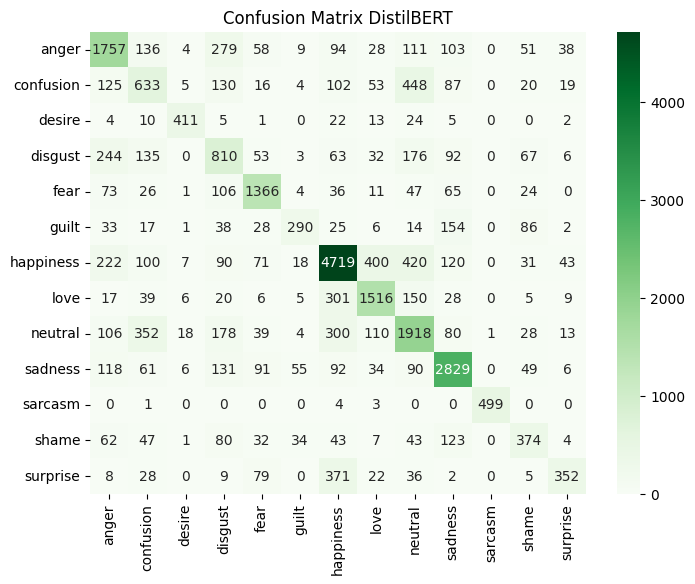

In [20]:
# Evaluasi
pred_distil = trainer_distil.predict(test_ds_distil)
y_pred_distil = np.argmax(pred_distil.predictions, axis=1)

print("=== Classification Report DistilBERT ===")
print(classification_report(
    y_test,
    y_pred_distil,
    target_names=le.classes_
))

cm_distil = confusion_matrix(y_test, y_pred_distil)

plt.figure(figsize=(8,6))
sns.heatmap(cm_distil, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Greens")
plt.title("Confusion Matrix DistilBERT")
plt.show()


In [21]:
# Simpan model
trainer_distil.save_model("results/distilbert_model")
distil_tokenizer.save_pretrained("results/distilbert_model")


('results/distilbert_model/tokenizer_config.json',
 'results/distilbert_model/special_tokens_map.json',
 'results/distilbert_model/vocab.txt',
 'results/distilbert_model/added_tokens.json')

In [22]:
import json
with open("results/distilbert_trainer_log.json", "w") as f:
    json.dump(trainer_distil.state.log_history, f, indent=2)
